In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *  # Import ARC (Alkali Rydberg Calculator)
from qutip import *
from scipy.fft import fft, ifft
from scipy import constants 

In [2]:
def C(F,m):
  return np.sqrt(F*(F+1)-m*(m+1))

In [3]:
# define parameters used for the simulation
Bx = 1e-3       # Magnetic field along x in T
By = 1e-3       # Magnetic field along y in T
omega_y = 1e3   # Magnetic field RF frequency in Hz
# constants
muB = 9.2740100783*1e-24 # Bohr magneton SI units
hbar = 1.05457182*1e-34  # reduced planck constant SI units
# Load parameters for Caesium from Library ARC
atom = Caesium()
# get the hyperfine structure coupling coefficients in Hz for each line
Coeff_ground    = atom.getHFSCoefficients(6,0,0.5) # 6S1/2
Coeff_D1        = atom.getHFSCoefficients(6,1,0.5) # 6P1/2
Coeff_D2        = atom.getHFSCoefficients(6,1,1.5) # 6P3/2
nu_hfs_ground   = Coeff_ground[0]   # nu_hfs in HZ
nu_hfs_D1       = Coeff_D1[0]       # nu_hfs in HZ
nu_hfs_D2       = Coeff_D2[0]       # nu_hfs in HZ

In [55]:
# Here is the Class alk_atom created by Maimouna Bocoum - 01-08-2023
class alk_atom:
    def __init__(self,myList:list):
        # test the type of the list and trck error
        #try:
            self.MakeAtomFromList(myList)

        # except:
        #     print("error in construction format inpout. exemple of acceptable inpout: [ [0,[3,4]] , [1,[3,4]] ]")
        # pass

    def AddLeveltoList(self,Level:list):
          # Level exemple of list structure: [0,[1,2]], for l=0 ; F=1 and F=2
        self.LevelList.append(Level)
        self.MakeAtomFromList()
        
    def MakeAtomFromList(self,myList):
            N = len(myList)
            self.LevelList = myList
            self.F = []
            self.L = []
            self.J = []
            self.M = []

            for loop in range(0,N):
                Line = myList[loop]  # get l orbital number. l=0 for 6S1/2 , l=1 for 6P1/2 and 6P3/2
                F = Line[2]          # get list of hyperfine F values
                for f in range(0,len(F)):
                     for m in range(0,F[f]*2+1):
                        self.L.append(Line[0])
                        self.J.append(Line[1])
                        self.F.append(F[f])
                        self.M.append( - F[f] + m )
            self.N = len(self.M)

            # count how many levels are not in the ground state
            self.N_notground = 0
            for loop in range(0,self.N):
                if [self.L[loop] , self.J[loop] , self.F[loop]]!=[0,0.5,3]:
                    self.N_notground = self.N_notground + 1

    def BuildMvector(self):
        self.M = []
        for i in range(0,len(self.F)):
             for m in range(0,self.F[i]*2+1):
                self.M.append( - self.F[i] + m )

    def printAtom(self):
        print(self.N)
        print(self.LevelList)
        print(self.L)
        print(self.J)
        print(self.F)
        print(self.M)



In [56]:
# initialize by list of line est hyperfine levels to account for
# exmple [l=0, F=[3,4]] is the 6S1/2 level, for F=3 and F=4.
# All mF level will be automatically filled by -F<= mF <= F.

# preparation state for the MORS in list of [[l,j,[F]]]
myList = [ [0,0.5,[3,4]] ]
my_cesium = alk_atom(myList)
my_cesium.printAtom()

print(my_cesium.N) # dimension of the Hilbert Space
print(my_cesium.N_notground) # dimension of the Hilbert Space excluding the ground state

16
[[0, 0.5, [3, 4]]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[-3, -2, -1, 0, 1, 2, 3, -4, -3, -2, -1, 0, 1, 2, 3, 4]
16
9


In [ ]:
# initialize quantum initial state
# by convention, the order of the basis is that of my_cesium.M
phi0 = basis(my_cesium.N,0)
for i in range(my_cesium.N_notground,my_cesium.N,1): # equidistribution of over all element of the Hilbert base
    phi0 += basis(my_cesium.N,i) 

phi0 = (1/phi0.norm())*phi0 # normalize intitial ket

print(phi0)
#print(my_cesium.M)
print(phi0.norm())

In [86]:
# self construction of spinnor operator
Sigma = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for i in range(0,my_cesium.N,1):
     for j in range(0,my_cesium.N,1):
        Sigma += basis(my_cesium.N, i)*basis(my_cesium.N, j).dag()

# self construction of Jx operator in hbar unit, where x is the quantization axis
Jx = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N,1):
        Jx.data[m,m] = my_cesium.M[m]

# self construction of Jy operator in hbar unit (Jy is adimensioned)
Jy = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
     Jy+=0.5*C(my_cesium.F[m],my_cesium.M[m])*( basis(my_cesium.N, m+1)*basis(my_cesium.N, m).dag() 
                                               + basis(my_cesium.N, m)*basis(my_cesium.N, m+1).dag() )
     # note that C(n,n) = 0 which makes this loop not overlap basis with different F values

# # self construction of Jz operator in hbar unit
Jz = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
    Jz+=-0.5*1j*C(my_cesium.F[m],my_cesium.M[m])*( basis(N, m+1)*basis(N, m).dag() - basis(N, m)*basis(N, m+1).dag() )


# Here, we create the adimension OMEGAs and OMEGAsqz operator in order to define the Hamiltoninan
OMEGAs          = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
OMEGAsqz        = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N,1):

        gf = atom.getLandegf( my_cesium.L[m] , my_cesium.J[m] , my_cesium.F[m] ) # get Landé coefficient getLandegf(s,j,F)

        OMEGAs.data[m,m] = gf # normalized value by (mu_B*B/hbar)
        OMEGAsqz.data[m,m] = 0.1
     # note that C(n,n) = 0 which makes this loop not overlap basis with different F values


# # self construction of atome hamiltoninan H0 operator in hbar unit, in absence of By RF field
H0 = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
H0 = OMEGAs*Jx + OMEGAsqz*Jx*Jx



c:\Users\Maimouna\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [87]:
# Collapse operators c_ops = [[C0, py_coeff0], C1, [C2, py_coeff2], ...] 
# We will consider that All level collapse exepct for the ground state (l=0,j=0.5,F=3). Loop should be performed on all other levels.
# not that all level are ordered by increasing energy so that collapse are each to populate in j>loop
Cops = [Qobj(dims=[[my_cesium.N],[my_cesium.N]]) for i in range(my_cesium.N)] # initializing an empty list

offset = my_cesium.N - my_cesium.N_notground # element to skip the the basis to reach first collapsing ket
for loop in range(0,my_cesium.N_notground,1): 

        for j in range(0,loop,1): # loop on all ket lower in energy than the current one
            # we now distinguish all case for the possible deacays
            if [my_cesium.L[loop] , my_cesium.J[loop] , my_cesium.F[loop]]==[0,0.5,4]:
                gamma = 10 # we set the decay rate to 10 Hz
                Cops[loop] = Cops[loop] + (gamma*constants.hbar)/(muB*Bx)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()
            elif [my_cesium.L[loop] , my_cesium.J[loop] , my_cesium.F[loop]]==[1,0.5,3]:
                gamma = atom.getStateLifetime(6,1,0.5, temperature=300,includeLevelsUpTo=7)
                Cops[loop] = Cops[loop] + (gamma*constants.hbar)/(muB*Bx)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()
            elif [my_cesium.L[loop] , my_cesium.J[loop] , my_cesium.F[loop]]==[1,1.5,3]:
                gamma = atom.getStateLifetime(6,1,1.5, temperature=300,includeLevelsUpTo=7)
                Cops[loop] = Cops[loop] + (gamma*constants.hbar)/(muB*Bx)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()


print((10*constants.hbar)/(muB*Bx))
print(my_cesium.N_notground)


1.1371260207207667e-07
9


In [88]:
def By(t,arg):
    return np.sin(2*np.pi*0.1*t)

In [89]:
# Simulation of the dynamic in absence of RF Magnetic field

rho0 = phi0*phi0.dag()
rho0 = rho0/np.sqrt(rho0.norm())

opts = Options()
opts.store_states = True
opts.store_final_state = True
#print(opts)

t = np.linspace(0, 100, 1000) # Define time vector
output = mesolve(H0, rho0, t, options=opts) # return a list density matrices over time in "output.states"

# evaluation traces of operators, loop on the list
meanJx = np.zeros(len(t))
meanJz = np.zeros(len(t))
meanJy = np.zeros(len(t))
meanRho = np.zeros(len(t))

for i in range(0,len(t)):
    tempJx = Jx*output.states[i]
    tempJy = Jy*output.states[i]
    tempJz = Jz*output.states[i]
    tempRho = output.states[i]*output.states[i]
    meanJx[i] = tempJx.norm()
    meanJy[i] = tempJy.norm()
    meanJz[i] = tempJz.norm()
    meanRho[i] = tempRho.norm()




Text(0.5, 0, 'Time')

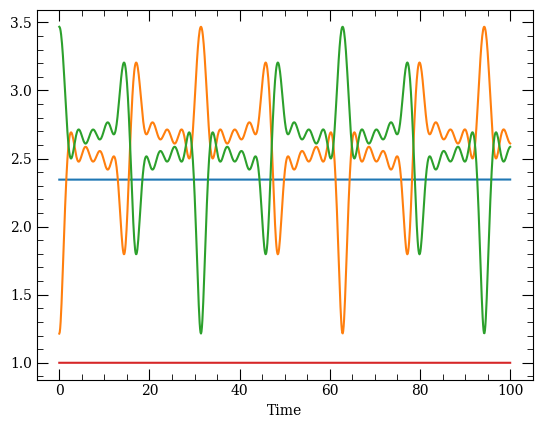

In [90]:
fig, ax = plt.subplots()
ax.plot(output.times, meanJx) 
ax.plot(output.times, meanJz) 
ax.plot(output.times, meanJy) 
ax.plot(output.times, meanRho) 
ax.set_xlabel('Time') 


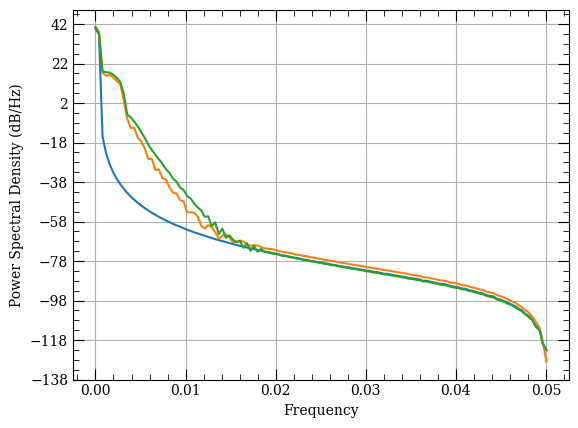

In [91]:
# plot Fourier transform of the result
Freqs = output.times[1] - output.times[0]
FFT_meanJx = plt.psd(meanJx,Fs=Freqs)
FFT_meanJy = plt.psd(meanJy,Fs=Freqs)
FFT_meanJz = plt.psd(meanJz,Fs=Freqs)

# print(type(FFT_meanJx[0]))
# fig
# plt.plot(FFT_meanJy[1],FFT_meanJy[0])